Printed and electronic copies of *Modeling and Simulation in Python* are available from [No Starch Press](https://nostarch.com/modeling-and-simulation-python) and [Bookshop.org](https://bookshop.org/p/books/modeling-and-simulation-in-python-allen-b-downey/17836697?ean=9781718502161) and [Amazon](https://amzn.to/3y9UxNb).

# Under the Hood

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [2]:
# import functions from modsim

from modsim import *

In this appendix we "open the hood," looking more closely at how some of
the tools we have used work: specifically, `run_solve_ivp`, `root_scalar`, and `maximize_scalar`.

Most of the time you don't need to know, you can use these methods without knowing much about how they work.
But there are a few reasons you might *want* to know.

One reason is pure curiosity. 
If you use these methods, and especially if you come to rely on them, you might find it unsatisfying to treat them as black boxes. 
In that case, you might enjoy opening the hood.

Another is that these methods are not infallible; sometimes things go wrong. 
If you know how they work, at least in a general sense, you might find it easier to debug them.

And if nothing else, I have found that I can remember how to use these tools more easily because I know something about how they work.

## How run_solve_ivp Works

`run_solve_ivp` is a function in the ModSimPy library that checks for common errors in the parameters and then calls `solve_ivp`, which is the function in the SciPy library that does the actual work.

By default, `solve_ivp` uses the *Dormand-Prince method*, which is a kind of *Runge-Kutta method*. You can read about it at
<https://en.wikipedia.org/wiki/Dormand-Prince_method>, but I'll give you a sense of
it here.

The key idea behind all Runge-Kutta methods is to evaluate the slope function several times at each time step and use a weighted average of the computed slopes to estimate the value at the next time step.
Different methods evaluate the slope function in different places and compute the average with different weights.

So let's see if we can figure out how `solve_ivp` works.
As an example, we'll solve the following differential equation:

$$\frac{dy}{dt}(t) = y \sin t$$

Here's the slope function we'll use:

In [3]:
import numpy as np

def slope_func(t, state, system):
    y, = state
    dydt = y * np.sin(t)
    return dydt

I'll create a `State` object with the initial state and a `System` object with the end time.

In [4]:
init = State(y=1)
system = System(init=init, t_end=3)

Now we can call `run_solve_ivp`.

In [5]:
results, details = run_solve_ivp(system, slope_func)
details

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 50
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7ff89741a3e0>
   status: 0
  success: True
 t_events: None
 y_events: None

One of the variables in `details` is `nfev`, which stands for "number of function evaluations", that is, the number of times `solve_ivp` called the slope function.
This example took 50 evaluations.
Keep that in mind.

Here are the first few time steps in `results`: 

In [6]:
results.head()

,y
0.00,1.000000
0.03,1.000450
0.06,1.001801
0.09,1.004055
0.12,1.007217


And here is the number of time steps.

In [7]:
len(results)

101

`results` contains 101 points that are equally spaced in time.
Now you might wonder, if `solve_ivp` ran the slope function 50 times, how did we get 101 time steps?

To answer that question, we need to know more about how the solver works.
There are actually three stages:

1. For each time step, `solve_ivp` evaluates the slope function seven times, with different values of `t` and `y`.

2. Using the results, it computes the best estimate for the value `y` at the next time step.

3. After computing all of the time steps, it uses interpolation to compute equally spaced points that connect the estimates from the previous step.

To show the first two steps, I'll modify the slope function so that every time it runs, it adds the values of `t`, `y`, and `dydt` to a list called `evals`.

In [8]:
def slope_func(t, state, system):
    y, = state
    dydt = y * np.sin(t)
    evals.append((t, y, dydt))
    return dydt

Before we call `run_solve_ivp`, I'll initialize `evals` with an empty list.
And I'll use the keyword argument `dense_output=False`, which skips the interpolation step and returns time steps that are not equally spaced (that is, not "dense").

In [9]:
evals = []
results2, details = run_solve_ivp(system, slope_func, dense_output=False)

Here are the results:

In [10]:
results2

,y
0.000000,1.000000
0.000100,1.000000
0.001100,1.000001
0.011100,1.000062
0.111100,1.006184
1.111100,1.744448
2.343272,5.464568
3.000000,7.318271


Because we skipped the interpolation step, we can see that `solve_ivp` computed only seven time steps, not including the initial condition.
Also, we see that the time steps are different sizes. 
The first is only 100 microseconds, the second is about 10 times bigger, and the third is 10 times bigger than that.

The time steps are not equal because the Dormand-Prince method is *adaptive*.
At each time step, it computes two estimates of the next
value. By comparing them, it can estimate the magnitude of the error,
which it uses to adjust the time step. If the error is too big, it uses
a smaller time step; if the error is small enough, it uses a bigger time
step. By adjusting the time step in this way, it minimizes the number
of times it calls the slope function to achieve a given level of
accuracy.
In this example, it takes five steps to simulate the first second, but then only two more steps to compute the remaining two seconds.

Because we saved the values of `y` and `t`, we can plot the locations where the slope function was evaluated.
I'll need to use a couple of features we have not seen before, if you don't mind.

First we'll unpack the values from `evals` using `np.transpose`.
Then we can use trigonometry to convert the slope, `dydt`, to components called `u` and `v`.

In [11]:
t, y, slope = np.transpose(evals)
theta = np.arctan(slope)
u = np.cos(theta)
v = np.sin(theta)

Using these values, we can generate a *quiver plot* that shows an arrow for each time the slope function ran.
The location of each arrow represents the values of `t` and `y`; the orientation of the arrow shows the slope that was computed.

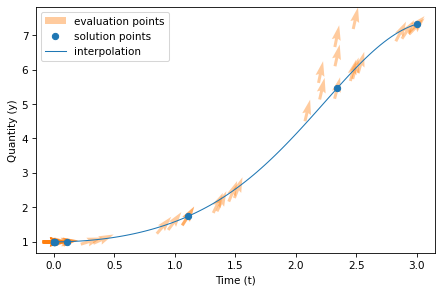

In [12]:
import matplotlib.pyplot as plt

plt.quiver(t, y, u, v, pivot='middle', 
           color='C1', alpha=0.4, label='evaluation points')
results2['y'].plot(style='o', color='C0', label='solution points')
results['y'].plot(lw=1, label='interpolation')

decorate(xlabel='Time (t)',
         ylabel='Quantity (y)')

In this figure, there are 50 arrows, one for each time the slope function was evaluated, and 8 dots, one for each time step (although several of them overlap).
The line shows the 101 points in the interpolation that connects the estimates.

Notice that many of the arrows do not fall on the line; `solve_ivp` evaluated the slope function at these locations in order to compute the solution, but as it turned out, they are not part of the solution.

This is good to know when you are writing a slope function; you should not assume that the time and state you get as input variables are correct.

## How root_scalar Works

`root_scalar` in the ModSim library is a wrapper for a function in the SciPy library with the same name.
Like `run_solve_ivp`, it checks for common errors and changes some of the parameters in a way that makes the SciPy function easier to use (I hope).

According to the documentation, `root_scalar` uses "a combination of bisection, secant, and inverse quadratic interpolation methods." (See
<https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html>)

To understand what that means, suppose we're trying to find a root of a
function of one variable, $f(x)$, and assume we have evaluated the
function at two places, $x_1$ and $x_2$, and found that the results have
opposite signs. Specifically, assume $f(x_1) > 0$ and $f(x_2) < 0$, as
shown in the following diagram:

![Initial state of a root-finding search](https://github.com/AllenDowney/ModSim/raw/main/figs/secant.png)

If $f$ is a continuous function, there must be at least one root in this
interval. In this case we would say that $x_1$ and $x_2$ *bracket* a
root.

If this were all you knew about $f$, where would you go looking for a
root? If you said "halfway between $x_1$ and $x_2$," congratulations!
`You just invented a numerical method called *bisection*!

If you said, "I would connect the dots with a straight line and compute
the zero of the line," congratulations! You just invented the *secant
method*!

And if you said, "I would evaluate $f$ at a third point, find the
parabola that passes through all three points, and compute the zeros of
the parabola," congratulations, you just invented *inverse quadratic
interpolation*!

That's most of how `root_scalar` works. The details of how these methods are
combined are interesting, but beyond the scope of this book. You can
read more at <https://en.wikipedia.org/wiki/Brents_method>.

## How maximize_scalar Works 

`maximize_scalar` in the ModSim library is a wrapper for a function in the SciPy library called `minimize_scalar`.
You can read about it at <https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html>.

By default, it uses Brent's method, which is related to the method I described in the previous section for root-finding.
Brent's method for finding a maximum or minimum is based on a simpler algorithm:
the *golden-section search*, which I will explain.

Suppose we're trying to find the minimum of a function of a single variable, $f(x)$.
As a starting place, assume that we have evaluated the function at three
places, $x_1$, $x_2$, and $x_3$, and found that $x_2$ yields the lowest
value. The following diagram shows this initial state.

![Initial state of a golden-section
search](https://github.com/AllenDowney/ModSim/raw/main/figs/golden1.png)

We will assume that $f(x)$ is continuous and *unimodal* in this range,
which means that there is exactly one minimum between $x_1$ and $x_3$.

The next step is to choose a fourth point, $x_4$, and evaluate $f(x_4)$.
There are two possible outcomes, depending on whether $f(x_4)$ is
greater than $f(x_2)$ or not.
The following figure shows the two possible states.

![](https://github.com/AllenDowney/ModSim/raw/main/figs/golden2.png)

If $f(x_4)$ is less than $f(x_2)$ (shown on the left), the minimum must
be between $x_2$ and $x_3$, so we would discard $x_1$ and proceed with
the new bracket $(x_2, x_4, x_3)$.

If $f(x_4)$ is greater than $f(x_2)$ (shown on the right), the local
minimum must be between $x_1$ and $x_4$, so we would discard $x_3$ and
proceed with the new bracket $(x_1, x_2, x_4)$.

Either way, the range gets smaller and our estimate of the optimal value
of $x$ gets better.

This method works for almost any value of $x_4$, but some choices are
better than others. You might be tempted to bisect the interval between
$x_2$ and $x_3$, but that turns out not to be optimal. You can
read about a better option at <https://greenteapress.com/matlab/golden>.